In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from utility import *

In [3]:
path = Path('/home/jupyter/.fastai/data/humpback')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/humpback/validation_random.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train'),
 PosixPath('/home/jupyter/.fastai/data/humpback/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/models')]

In [4]:
df_train = preprocess(path/'train.csv')
df_known_whale = df_train[df_train.Id!='new_whale']
df_known_whale.describe()

,Image,Id,is_valid
count,15697,15697,15697
unique,15697,5004,2
top,276da5deb.jpg,w_23a388d,False
freq,1,73,13241


# End of Preprocessing

In [5]:
src = (ImageList
      .from_df(df_known_whale,path=path,folder='train')
      .split_from_df(col='is_valid')
      .label_from_df(cols='Id'))

In [6]:
data = (src
       .transform(get_transforms(max_zoom=1,max_warp=0),size=224,resize_method=ResizeMethod.SQUISH)
       .databunch()
       .normalize(imagenet_stats))

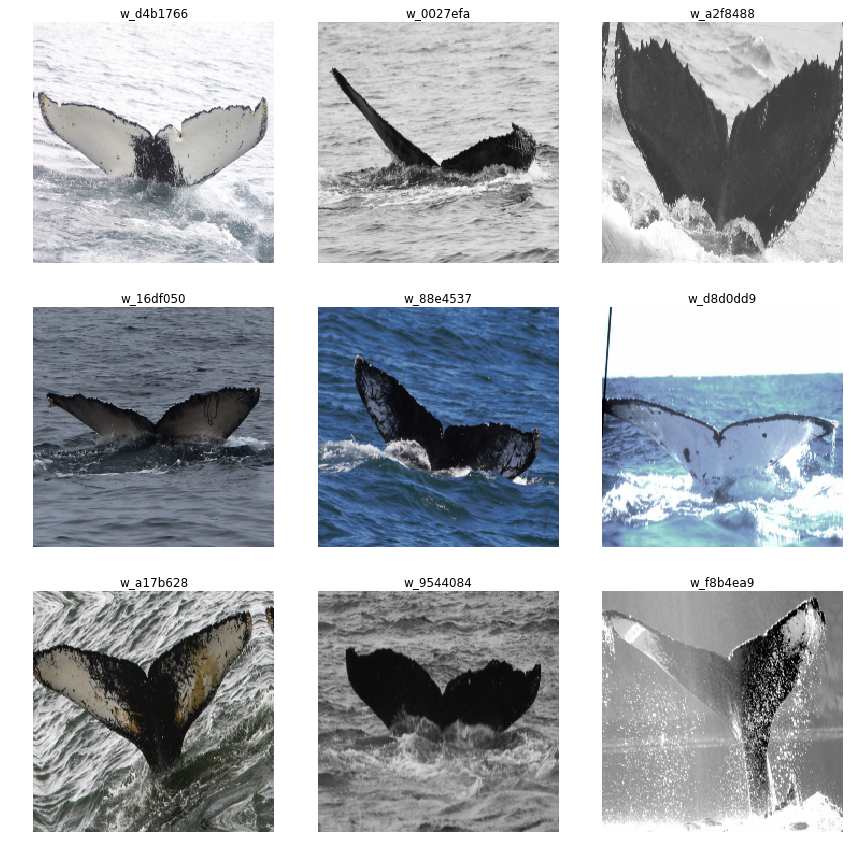

In [11]:
data.show_batch(rows=3)

In [8]:
learn = create_cnn(data,models.resnet50,metrics=[accuracy,mapk])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


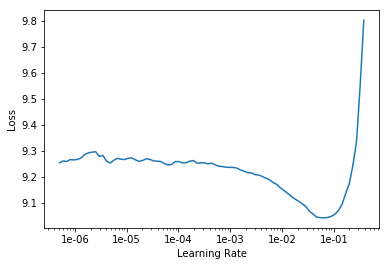

In [14]:
learn.lr_find(end_lr=1)
learn.recorder.plot()

In [15]:
lr = 8e-3

In [16]:
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,accuracy,mapk,time
1,8.050980,6.720334,0.100570,0.137147,02:22
2,6.837221,5.143425,0.233306,0.280490,02:21
3,5.176306,4.076797,0.341205,0.399851,02:21
4,3.517475,3.842261,0.379072,0.438138,02:22


In [17]:
learn.save('resnet50-known_whale-224-stage-1')

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


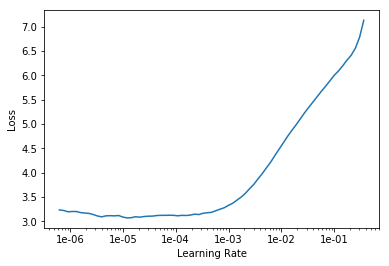

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,mapk,time
1,3.662341,3.913496,0.375000,0.432051,02:59
2,4.081850,3.564936,0.415717,0.479988,03:01
3,3.286401,3.175245,0.475977,0.534697,03:01
4,2.286222,2.901135,0.521987,0.579913,03:00
5,1.698753,2.860765,0.525651,0.583218,02:59


In [21]:
learn.save('resnet50-know_whale-224-stage-2')

In [10]:
learn.data.add_test(ImageList.from_folder(path=path/'test'))

# Fin

In [11]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [12]:
preds = preds[0]
preds.shape

torch.Size([7960, 5004])

In [13]:
top_5 = torch.argsort(preds,dim=1,descending=True)
top_5.shape

torch.Size([7960, 5004])

In [14]:
result = top_5[:,0:5]
result.shape

torch.Size([7960, 5])

In [17]:
results = result.numpy()

In [75]:
labels = []
for i in results:
    labels.append(' '.join([data.classes[idx] for idx in i]))

In [76]:
sub = pd.DataFrame({'Image':[path.name for path in data.test_ds.items]})

In [77]:
sub['Id'] = labels

In [78]:
sub.head()

,Image,Id
0,8fe153df5.jpg,w_ae19ff0 w_2972f31 w_6c995fd w_bc7de9f w_01cbbbd
1,a0f38fccb.jpg,w_ab2ac77 w_84a32d1 w_7c27fbd w_b9d5945 w_edce644
2,65a1c41f2.jpg,w_39141fc w_817d53c w_3643be7 w_94e136e w_2c94198
3,acc799677.jpg,w_1ca9ab1 w_91cc02c w_e54d8f6 w_a8276b4 w_0887d9b
4,7ed205c6c.jpg,w_d573a68 w_bf2b915 w_dea40e2 w_5d1b1a7 w_13ca7e8


In [79]:
new_whale_result = pd.read_csv('new_whale_detector.csv')
new_whale_result.head()

,Image,Id
0,8fe153df5.jpg,new_whale
1,a0f38fccb.jpg,new_whale
2,65a1c41f2.jpg,known_whale
3,acc799677.jpg,new_whale
4,7ed205c6c.jpg,known_whale


In [80]:
df_final = pd.merge(left=new_whale_result,right=sub,on='Image',how='left')
df_final.head()

,Image,Id_x,Id_y
0,8fe153df5.jpg,new_whale,w_ae19ff0 w_2972f31 w_6c995fd w_bc7de9f w_01cbbbd
1,a0f38fccb.jpg,new_whale,w_ab2ac77 w_84a32d1 w_7c27fbd w_b9d5945 w_edce644
2,65a1c41f2.jpg,known_whale,w_39141fc w_817d53c w_3643be7 w_94e136e w_2c94198
3,acc799677.jpg,new_whale,w_1ca9ab1 w_91cc02c w_e54d8f6 w_a8276b4 w_0887d9b
4,7ed205c6c.jpg,known_whale,w_d573a68 w_bf2b915 w_dea40e2 w_5d1b1a7 w_13ca7e8


In [81]:
df_final['Id'] = df_final.Id_x + ' ' + df_final.Id_y
df_final.head()

,Image,Id_x,Id_y,Id
0,8fe153df5.jpg,new_whale,w_ae19ff0 w_2972f31 w_6c995fd w_bc7de9f w_01cbbbd,new_whale w_ae19ff0 w_2972f31 w_6c995fd w_bc7d...
1,a0f38fccb.jpg,new_whale,w_ab2ac77 w_84a32d1 w_7c27fbd w_b9d5945 w_edce644,new_whale w_ab2ac77 w_84a32d1 w_7c27fbd w_b9d5...
2,65a1c41f2.jpg,known_whale,w_39141fc w_817d53c w_3643be7 w_94e136e w_2c94198,known_whale w_39141fc w_817d53c w_3643be7 w_94...
3,acc799677.jpg,new_whale,w_1ca9ab1 w_91cc02c w_e54d8f6 w_a8276b4 w_0887d9b,new_whale w_1ca9ab1 w_91cc02c w_e54d8f6 w_a827...
4,7ed205c6c.jpg,known_whale,w_d573a68 w_bf2b915 w_dea40e2 w_5d1b1a7 w_13ca7e8,known_whale w_d573a68 w_bf2b915 w_dea40e2 w_5d...


In [82]:
df_final.drop(['Id_x','Id_y'],axis=1,inplace=True)
df_final.head()

,Image,Id
0,8fe153df5.jpg,new_whale w_ae19ff0 w_2972f31 w_6c995fd w_bc7d...
1,a0f38fccb.jpg,new_whale w_ab2ac77 w_84a32d1 w_7c27fbd w_b9d5...
2,65a1c41f2.jpg,known_whale w_39141fc w_817d53c w_3643be7 w_94...
3,acc799677.jpg,new_whale w_1ca9ab1 w_91cc02c w_e54d8f6 w_a827...
4,7ed205c6c.jpg,known_whale w_d573a68 w_bf2b915 w_dea40e2 w_5d...


In [83]:
df_final.Id = df_final.Id.str.replace('known_whale ?','')

In [84]:
df_final.head()

,Image,Id
0,8fe153df5.jpg,new_whale w_ae19ff0 w_2972f31 w_6c995fd w_bc7d...
1,a0f38fccb.jpg,new_whale w_ab2ac77 w_84a32d1 w_7c27fbd w_b9d5...
2,65a1c41f2.jpg,w_39141fc w_817d53c w_3643be7 w_94e136e w_2c94198
3,acc799677.jpg,new_whale w_1ca9ab1 w_91cc02c w_e54d8f6 w_a827...
4,7ed205c6c.jpg,w_d573a68 w_bf2b915 w_dea40e2 w_5d1b1a7 w_13ca7e8


In [85]:
df_final.to_csv('combined.csv',index=False)

# Testing

In [44]:

preds = df_final.Id.tolist()
result = []
for pred in preds:
    if (len(pred)!=5):
        result.append(pred.split(' ')[0:5])
    else:
        result.append(pred)

In [57]:
df_final.head()

,Image,Id
0,8fe153df5.jpg,"[new_whale, w_ae19ff0, w_2972f31, w_6c995fd, w..."
1,a0f38fccb.jpg,"[new_whale, w_ab2ac77, w_84a32d1, w_7c27fbd, w..."
2,65a1c41f2.jpg,"[w_39141fc, w_817d53c, w_3643be7, w_94e136e, w..."
3,acc799677.jpg,"[new_whale, w_1ca9ab1, w_91cc02c, w_e54d8f6, w..."
4,7ed205c6c.jpg,"[w_d573a68, w_bf2b915, w_dea40e2, w_5d1b1a7, w..."


In [56]:
test = ','.join(result[0])
test

'new_whale,w_ae19ff0,w_2972f31,w_6c995fd,w_bc7de9f'

In [66]:
df_final.Id = result
df_final.head()

,Image,Id
0,8fe153df5.jpg,"[new_whale, w_ae19ff0, w_2972f31, w_6c995fd, w..."
1,a0f38fccb.jpg,"[new_whale, w_ab2ac77, w_84a32d1, w_7c27fbd, w..."
2,65a1c41f2.jpg,"[w_39141fc, w_817d53c, w_3643be7, w_94e136e, w..."
3,acc799677.jpg,"[new_whale, w_1ca9ab1, w_91cc02c, w_e54d8f6, w..."
4,7ed205c6c.jpg,"[w_d573a68, w_bf2b915, w_dea40e2, w_5d1b1a7, w..."


In [64]:
df_final.Id=df_final.Id.str.replace('\[?','')
df_final.Id=df_final.Id.str.replace(']?','')
df_final.Id=df_final.Id.str.replace(',?','')

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [65]:
df_final.head()

,Image,Id
0,8fe153df5.jpg,NaN
1,a0f38fccb.jpg,NaN
2,65a1c41f2.jpg,NaN
3,acc799677.jpg,NaN
4,7ed205c6c.jpg,NaN
